# Shapley Values

In [2]:
# !pip install shap==0.40.0

In [2]:
# Import the SHAP library - https://github.com/slundberg/shap
import shap
import xgboost
import tensorflow as tf
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [4]:
print(f'The scikit-learn version is {sklearn.__version__}.')  # 1.0.1
print(f'The tensorflow version is {tf.__version__}.')  # 2.4.0
print(f'The shap version is {shap.__version__}.')  # 0.40.0
print(f'The xgboost version is {xgboost.__version__}.')  # 1.5.0

The scikit-learn version is 1.2.1.
The tensorflow version is 2.11.0.
The shap version is 0.41.0.
The xgboost version is 1.7.4.


## For Regression task

### Load the California Housing dataset.

In [5]:
cal_housing = fetch_california_housing()

In [6]:
print(cal_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [7]:
X = cal_housing.data
y = cal_housing.target
cal_features = cal_housing.feature_names

df = pd.concat((pd.DataFrame(X, columns=cal_features),
                pd.DataFrame({'MedianHouseVal': y})), axis=1)

In [8]:
df.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedianHouseVal  
0    -122.23           4.526  
1    -122.22           3.585  
2    -122.24           3.521  
3    -122.25           3.413  
4    -122.25           3.422

In [9]:
# Create dataset for train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Train an XGBoost model

In [10]:
xgb_reg = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=500)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [11]:
def compute_mse(preds, labels):
    return np.mean((preds - labels)**2)

In [12]:
test_preds = np.squeeze(xgb_reg.predict(X_test))
mse_test = compute_mse(test_preds, y_test)
print(f'The RMSE for our XGBoost model is {np.sqrt(mse_test)}')

The RMSE for our XGBoost model is 0.46876353846505375


#### Use `shap` to compute SHAP values

In [13]:
explainer = shap.Explainer(xgb_reg, feature_names=cal_features)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The `explainer` produces an Explanation object.

In [14]:
type(shap_values)

shap._explanation.Explanation

In [18]:
first_row_shap = shap_values[0]
shapley_values = first_row_shap.values

In [20]:
# predicted
first_row_shap.base_values + sum(shapley_values)

0.5688169915229082

In [21]:
first_row_shap.base_values

2.0760207

In [22]:
shapley_values

array([-0.476177  , -0.01783975, -0.10141787,  0.03548361, -0.03857079,
       -0.06985363, -0.49252468, -0.3463036 ], dtype=float32)

In [15]:
#should be the shape of the X_test array
assert shap_values.shape == X_test.shape

Examine global explanations.

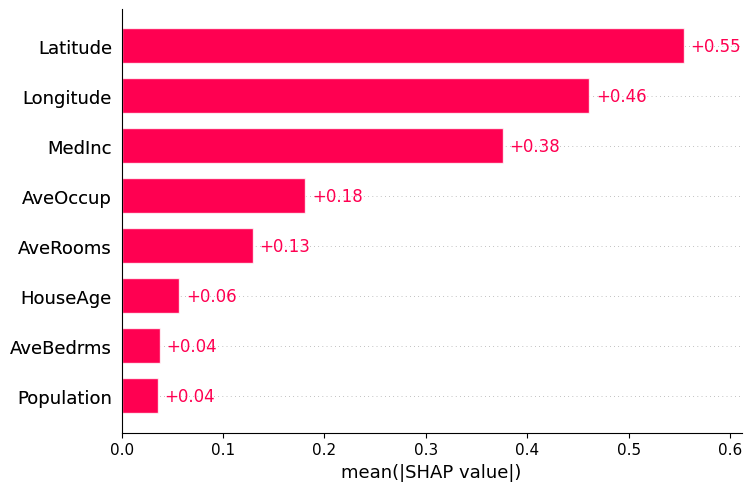

In [16]:
shap.plots.bar(shap_values)

In [20]:
shap.initjs()
shap.plots.force(shap_values)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


In [24]:
shap.plots.force(shap_values[:,"MedInc"])

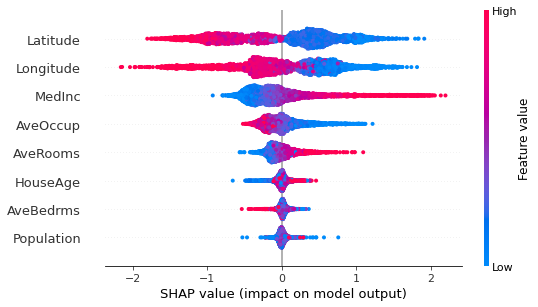

In [23]:
shap.plots.beeswarm(shap_values)

Look at individual predictions

MedInc: 	 2.325
HouseAge: 	 35.0
AveRooms: 	 5.171428571428572
AveBedrms: 	 1.0615384615384615
Population: 	 1368.0
AveOccup: 	 3.0065934065934066
Latitude: 	 35.42
Longitude: 	 -119.05


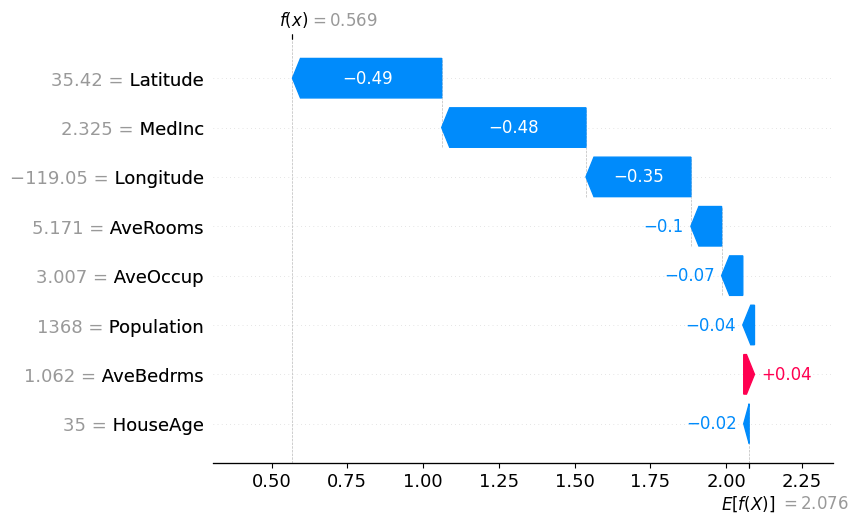

In [23]:
# visualize the first prediction's explanation

idx = 0   # index of example to explore

text_example = X_test[idx]
for i, feature in enumerate(cal_features):
    print(f'{feature}: \t {text_example[i]}')
    
shap.plots.waterfall(shap_values[idx])

In [42]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[idx])

In [26]:
first_row_shap = shap_values[0]
shapley_values = first_row_shap.values

print(f'Predicted Value: {first_row_shap.base_values + sum(shapley_values)}\n')
print(f'Baseline: {first_row_shap.base_values}\n')

print('Shapley values for features:')
for i, shapley_value in enumerate(shapley_values):
    print(f'{shap_values.feature_names[i]}: {shapley_value}')

print('\nMost to least influential features:')
most_influential_ordering = np.argsort(-np.abs(shapley_values))
for i in range(len(shapley_values)):
    print(f'{shap_values.feature_names[most_influential_ordering[i]]}: {shapley_values[most_influential_ordering[i]]}')

Predicted Value: 2.3797756880521774

Baseline: 2.0696914196014404

Shapley values for features:
MedInc: -0.11836741119623184
HouseAge: 0.028192710131406784
AveRooms: 0.08699220418930054
AveBedrms: 0.007484322413802147
Population: 0.022417431697249413
AveOccup: -0.250638484954834
Latitude: 0.6717623472213745
Longitude: -0.13775885105133057

Most to least influential features:
Latitude: 0.6717623472213745
AveOccup: -0.250638484954834
Longitude: -0.13775885105133057
MedInc: -0.11836741119623184
AveRooms: 0.08699220418930054
HouseAge: 0.028192710131406784
Population: 0.022417431697249413
AveBedrms: 0.007484322413802147


In [32]:
text_example = X_test[0]
for i, feature in enumerate(cal_features):
    print(f'{feature}: \t {text_example[i]}')

MedInc: 	 3.5625
HouseAge: 	 43.0
AveRooms: 	 5.64741641337386
AveBedrms: 	 1.0486322188449848
Population: 	 1054.0
AveOccup: 	 3.2036474164133737
Latitude: 	 34.11
Longitude: 	 -118.01


In [41]:
print(f"The model prediction value for this example is {np.mean(xgb_reg.predict([X_test[0]]))}")
print(f"The baseline prediction value for our model is {np.mean(xgb_reg.predict(X_test))}")

The model prediciton value for this example is 2.3797760009765625
The baseline prediciton value for our model is 2.0721733570098877


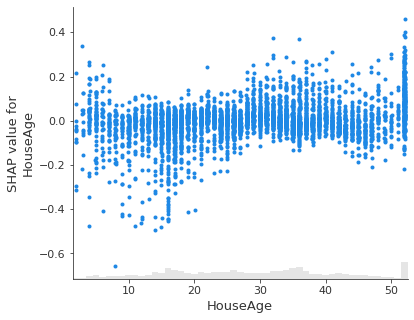

In [43]:
shap.plots.scatter(shap_values[:,"HouseAge"])

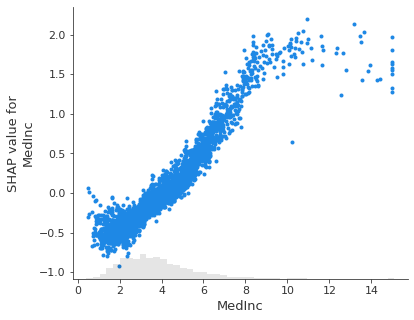

In [44]:
shap.plots.scatter(shap_values[:,"MedInc"])

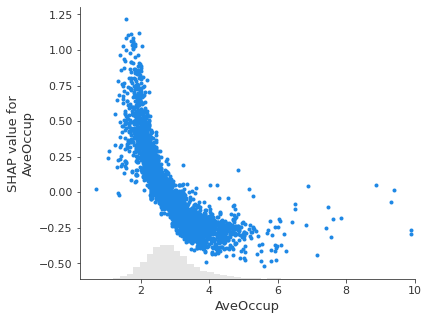

In [45]:
shap.plots.scatter(shap_values[:,"AveOccup"], xmax=10)

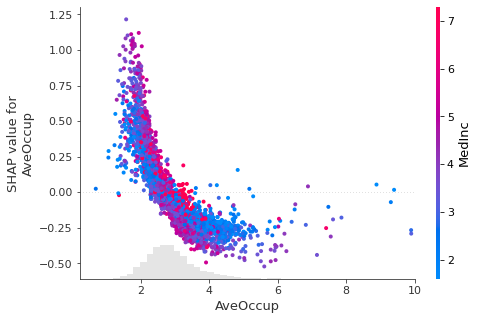

In [46]:
shap.plots.scatter(shap_values[:,"AveOccup"], xmax=10, color=shap_values)

Let's look at the scatter plot for all features.

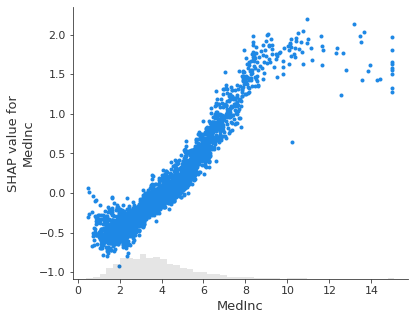

In [47]:
shap.plots.scatter(shap_values[:,"MedInc"])

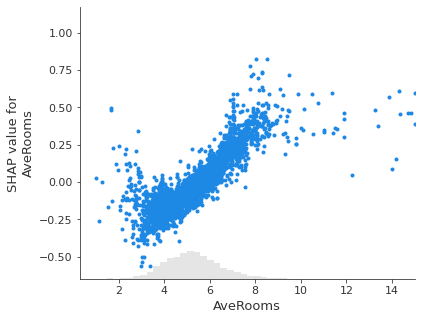

In [48]:
shap.plots.scatter(shap_values[:,"AveRooms"], xmax=15)

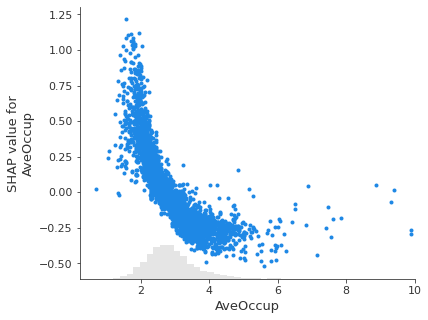

In [49]:
shap.plots.scatter(shap_values[:,"AveOccup"], xmax=10)

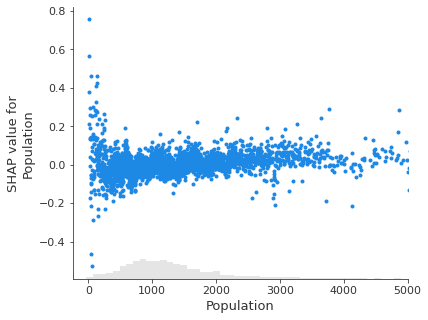

In [50]:
shap.plots.scatter(shap_values[:,"Population"], xmax=5000)

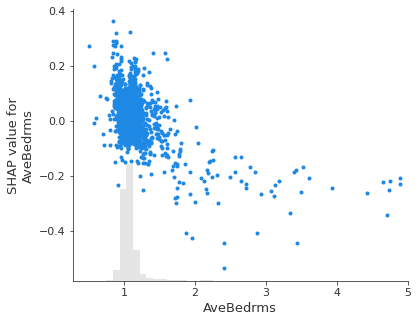

In [51]:
shap.plots.scatter(shap_values[:,"AveBedrms"], xmax=5)

### Train a model in Tensorflow

In [25]:
# for the shap library to work properly
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [26]:
# helper functions to normalize the feature array and compute MSE
def normalize(np_array):
    array_mean = np.mean(np_array, axis=0)
    array_std = np.std(np_array, axis=0)
    return (np_array - array_mean) / array_std

In [27]:
# Build and train model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation=tf.nn.relu, input_shape=[len(X_train[0])]),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dense(8, activation=tf.nn.relu),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

tf_model = build_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = tf_model.fit(normalize(X_train), y_train, epochs=60, verbose=0,
                       validation_data = (normalize(X_test), y_test),
                       callbacks=[early_stopping]
                      )

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [28]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error ($1000]')
    plt.plot(history['epoch'], history['mean_squared_error'], label='Train Error')
    plt.plot(history['epoch'], history['val_mean_squared_error'], label = 'Val Error')
    plt.legend()

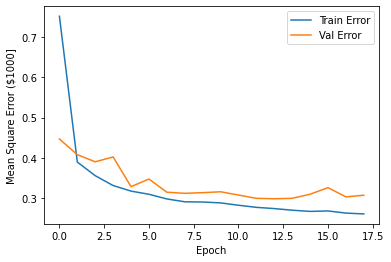

In [29]:
plot_history(hist)

In [30]:
test_preds = np.squeeze(tf_model.predict(normalize(X_test)))
mse_test = compute_mse(test_preds, y_test)
print(f'The RMSE for our TF model is {np.sqrt(mse_test)}')

The RMSE for our TF model is 0.5543340579888976


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


#### Use `shap` to compute SHAP values

In [ ]:
# compute SHAP values, this takes some time for a large dataset
explainer = shap.DeepExplainer(tf_model, X_train)
shap_values = explainer.shap_values(X_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


`shap_values` should have the same shape as X_test

In [35]:
assert shap_values[0].shape == X_test.shape

Let's look at global explanations.

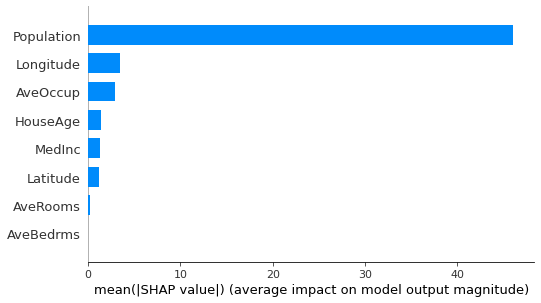

In [36]:
shap.summary_plot(shap_values[0], plot_type='bar', feature_names=cal_features)

Look at individual predictions.

In [37]:
idx = 0   # index of example to explore

text_example = X_test[idx]
for i, feature in enumerate(cal_features):
    print(f'{feature}: \t {text_example[i]}')
    
shap.initjs()
shap.force_plot(explainer.expected_value[0],
                shap_values[0][idx],
                features=cal_features)

MedInc: 	 5.679
HouseAge: 	 20.0
AveRooms: 	 6.401273885350318
AveBedrms: 	 1.070063694267516
Population: 	 457.0
AveOccup: 	 2.910828025477707
Latitude: 	 38.56
Longitude: 	 -122.05


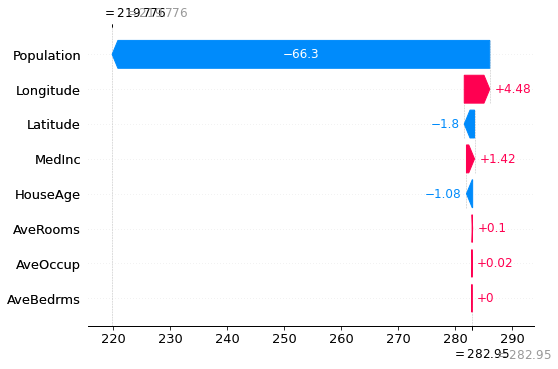

In [38]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       shap_values[0][idx],
                                       feature_names=cal_features)

In [39]:
idx = 1   # index of example to explore

text_example = X_test[idx]
for i, feature in enumerate(cal_features):
    print(f'{feature}: \t {text_example[i]}')
    
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx], features=cal_features)

MedInc: 	 3.5192
HouseAge: 	 24.0
AveRooms: 	 5.909706546275395
AveBedrms: 	 1.0948081264108351
Population: 	 726.0
AveOccup: 	 1.6388261851015802
Latitude: 	 33.01
Longitude: 	 -117.06


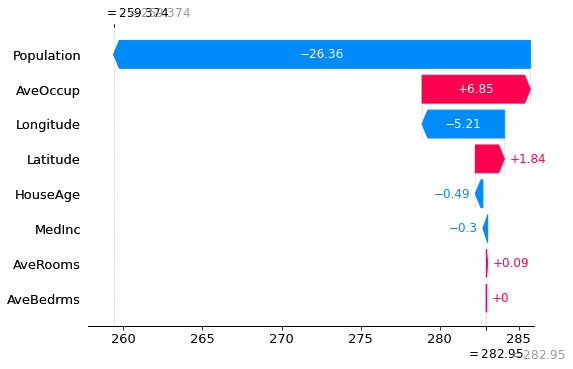

In [40]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                       shap_values[0][idx],
                                       feature_names=cal_features)

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License